## 1. Line Noise Removal

* <b>CleanLineNoise</b> removes the line frequency (50 or 60 Hz) and harmonics that are multiples of the line frequency up to the Nyquist frequency.
    

Removed notch frequencies (Hz):
     50.00 :   56 windows
    100.00 :   56 windows


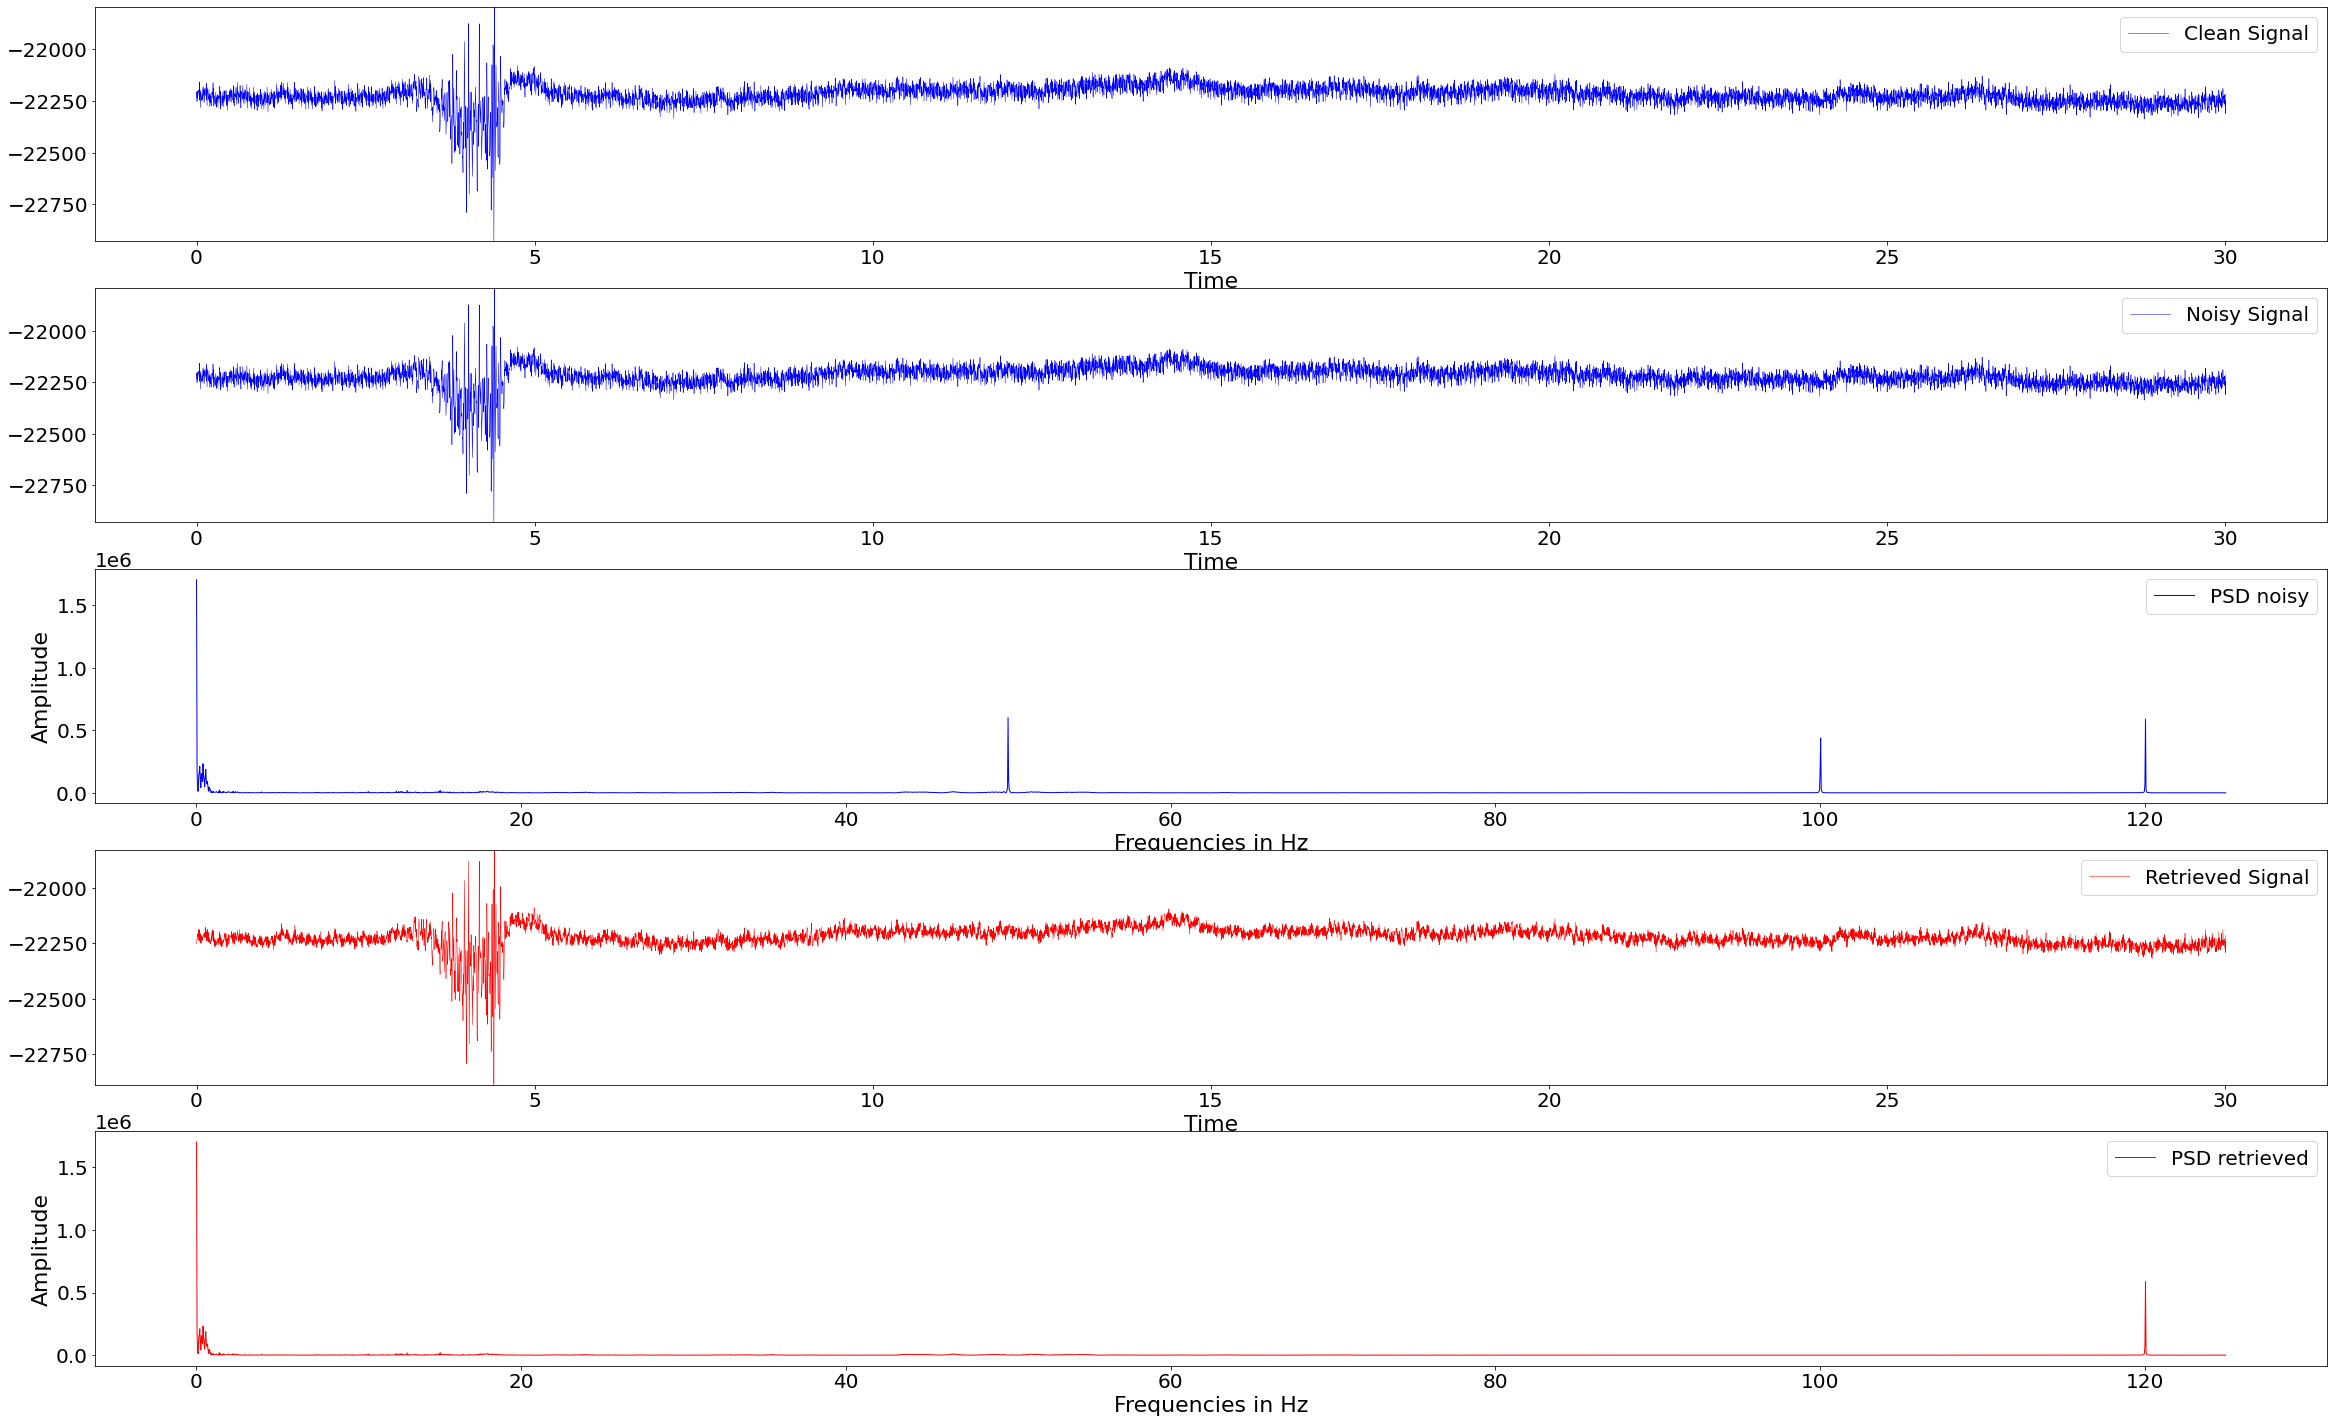

In [2]:
import numpy as np
import mne
import matplotlib.pyplot as plt

# a. Reading in our ExG signal
ExG_in = np.transpose( np.genfromtxt("offline_exp_ExG-30s.csv", delimiter = ',') )
ExG_in = ExG_in[:, 1:]
# timestamps start at 0 s
ExG_in[0] = ExG_in[0] - ExG_in[0][0]
s_rate = 250
ln_freq = 50 # Line frequency = 50 Hz


# b. Adding components at the line frequency + harmonics and frequencies > 100 Hz
dt = ExG_in[0][1] - ExG_in[0][0]
t = ExG_in[0]
line_signal = 20 * ( np.sin(2*np.pi*50*t) + np.sin(2*np.pi*100*t) + np.sin(2*np.pi*120*t) )
ExG_signal = ExG_in
ExG_signal[1:] = ExG_in[1:] + line_signal

#       Commpute Fourier Transform
n = len(t)
fhat = np.fft.fft(ExG_signal[1], n) # computes the fft
psd = fhat * np.conj(fhat)/n
freq = (1/(dt*n)) * np.arange(n) # frequency array
idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) # first half index


# c. Removing the line noise
ln_freqs = np.arange(ln_freq, s_rate/2, ln_freq)
ExG_lnrm = mne.filter.notch_filter( ExG_signal[1:, :],
                                    Fs = s_rate,
                                    freqs = ln_freqs,
                                    method = "spectrum_fit",
                                    mt_bandwidth = 2,
                                    p_value = 0.01,
                                    filter_length = "4s")
tmp = ExG_signal[0, :]
# include the timestamps
ExG_lnrm = np.transpose( np.c_[tmp, np.transpose(ExG_lnrm)] )

#       Compute Fourier Transform
fhat_lnrm = np.fft.fft(ExG_lnrm[1])
psd_lnrm = fhat_lnrm * np.conj(fhat_lnrm)/n

# d. Plotting the spectrum before and after the Line noise removal
plt.rcParams['figure.figsize'] = [40, 25]
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', labelsize = MEDIUM_SIZE)    # fontsize of the x and y labels 


fig, ax = plt.subplots(5,1)

ax[0].plot(t, ExG_in[1], color='b', lw=0.5, label='Clean Signal')
ax[0].set_ylim([ExG_in[1].min(), ExG_in[1].max()])
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].plot(t, ExG_signal[1], color='b', lw=0.5, label='Noisy Signal')
ax[1].set_ylim([ExG_signal[1].min(), ExG_signal[1].max()])
ax[1].set_xlabel('Time')
ax[1].legend()

ax[2].plot(freq[idxs_half], np.abs(psd[idxs_half]), color='b', lw=1, label='PSD noisy')
ax[2].set_xlabel('Frequencies in Hz')
ax[2].set_ylabel('Amplitude')
ax[2].legend()

ax[3].plot(t, ExG_lnrm[1], color='r', lw=0.5, label='Retrieved Signal')
ax[3].set_ylim([ExG_lnrm[1].min(), ExG_lnrm[1].max()])
ax[3].set_xlabel('Time')
ax[3].legend()

ax[4].plot(freq[idxs_half], np.abs(psd_lnrm[idxs_half]), color='r', lw=1, label='PSD retrieved')
ax[4].set_xlabel('Frequencies in Hz')
ax[4].set_ylabel('Amplitude')
ax[4].legend()

## 2. Filtering
* Applying a lowpass filter at frequency 100 Hz

Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 33 samples (0.132 sec)



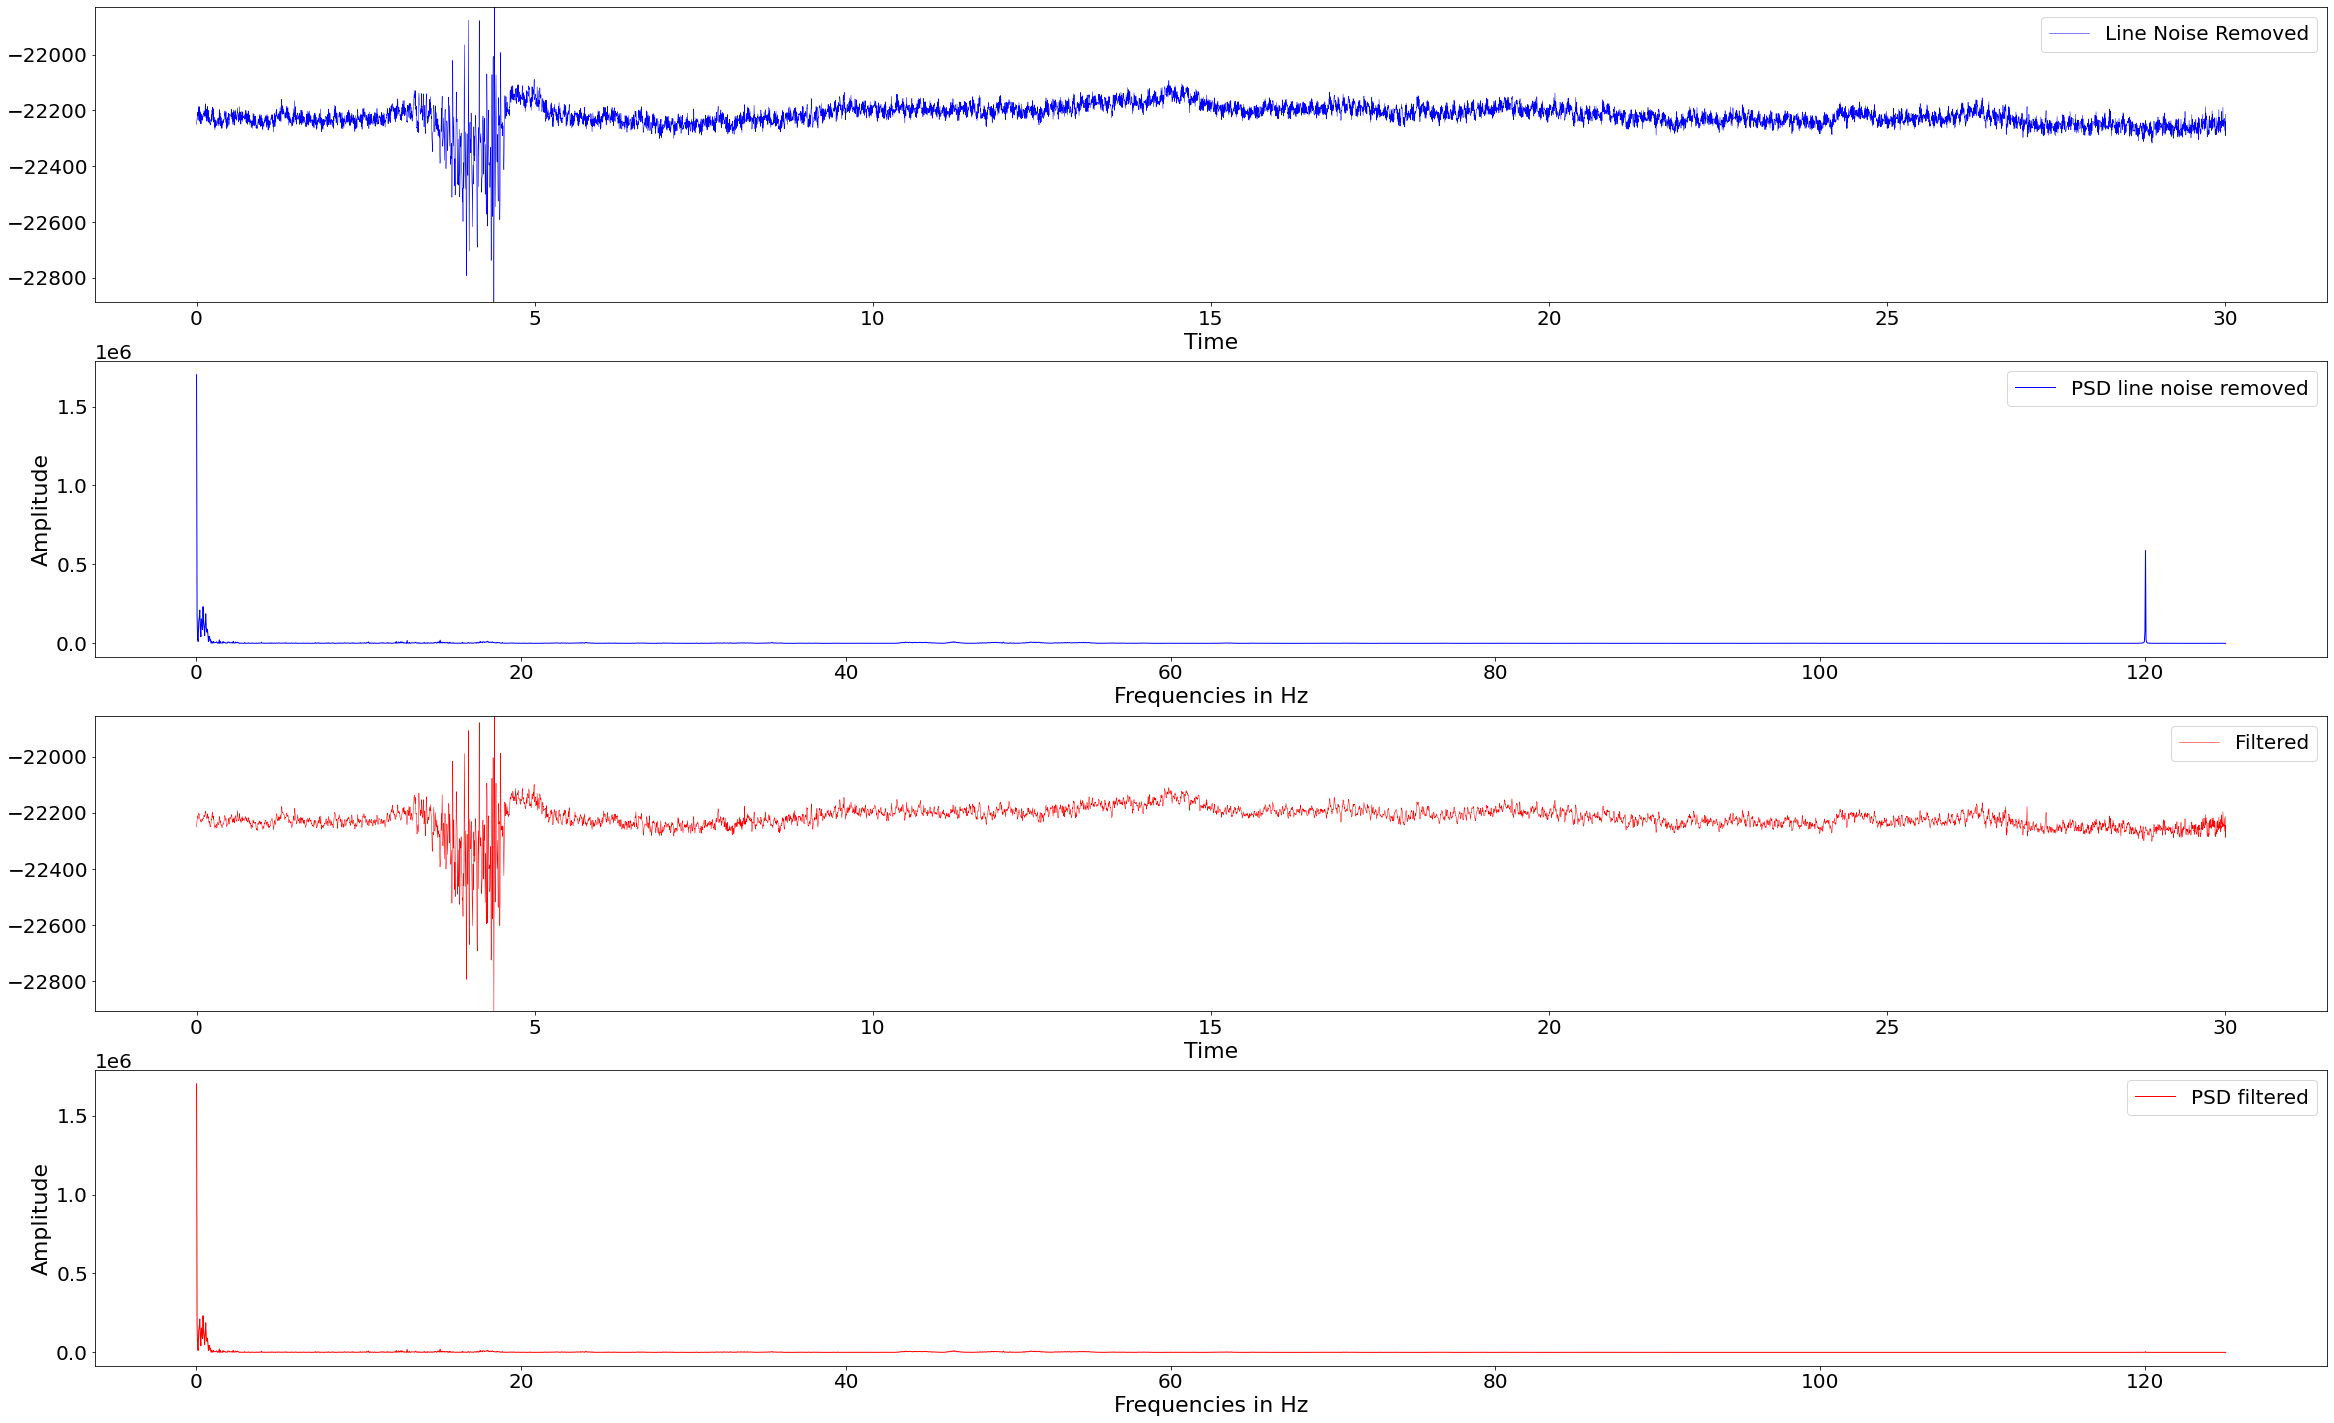

In [3]:
s_rate = 250
ExG_filt = mne.filter.filter_data(ExG_lnrm[1:, :],
                                            sfreq = s_rate,
                                            h_freq = 100,
                                            l_freq = None)
tmp = ExG_signal[0, :]
# include the timestamps
ExG_filt = np.transpose( np.c_[tmp, np.transpose(ExG_filt)] )

#       Compute Fourier Transform
t = ExG_in[0]
n = len(t)
fhat_filt = np.fft.fft(ExG_filt[1])
psd_filt = fhat_filt * np.conj(fhat_filt)/n


# d. Plotting the spectrum before and after the Line noise removal
fig, ax = plt.subplots(4,1)
plt.rcParams['figure.figsize'] = [40, 25]
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', labelsize = MEDIUM_SIZE)    # fontsize of the x and y labels 

ax[0].plot(t, ExG_lnrm[1], color='b', lw=0.5, label='Line Noise Removed')
ax[0].set_ylim([ExG_lnrm[1].min(), ExG_lnrm[1].max()])
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].plot(freq[idxs_half], np.abs(psd_lnrm[idxs_half]), color='b', lw=1, label='PSD line noise removed')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(t, ExG_filt[1], color='r', lw=0.5, label='Filtered')
ax[2].set_ylim([ExG_filt[1].min(), ExG_filt[1].max()])
ax[2].set_xlabel('Time')
ax[2].legend()

ax[3].plot(freq[idxs_half], np.abs(psd_filt[idxs_half]), color='r', lw=1, label='PSD filtered')
ax[3].set_xlabel('Frequencies in Hz')
ax[3].set_ylabel('Amplitude')
ax[3].legend()


In [4]:
# Export filtered signal to process on MATLAB
np.savetxt('ExG_filt.csv', np.transpose(ExG_filt[1]), delimiter=",")

## 3. Wavelet Thresholding
1. Wavelet Transform  
    * Each electrode’s time series is subjected to wavelet transform.
    * Chosen wavelet function: Coiflet order 4 (`coif4`)
    * Level of Data Decomposition:
        * if sampling rate > 500 Hz = `10`
        * if 250 Hz < sampling rate <= 500 Hz = `9`
        * if sampling rate <= 250 Hz = `8`
2. Determining threshold values for each level
    * Wavelet coefficients are then subjected to thresholding (in a `level-dependent` way)
    * The chosen method to determine these threshold values: `Bayes`   
    (I. M. Johnstone, B. W. Silverman (2005). [Empirical Bayes Selection of Wavelet Thresholds](https://arxiv.org/pdf/math/0508281.pdf)) 
3. Thresholding
    * Thresholding rule: `Hard`
4. Reconstruction
    * The resulting coefficients are reconstructed into a signal

### a. Universal Threshold

In [5]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Universal threshold
def get_level_thd(level_coef: np.array):
    """
    Calculates the threshold value for each wavelet level
    Args:
        level_coef: a numpy array containing the coefficients for the current level
    Returns:
        level_thd   : a threshold value for the current level
    """
    level_median = np.median(np.abs(level_coef))
    n = len(level_coef)
    level_thd = (level_median/0.75) * np.sqrt(2*np.log(n))
    return level_thd



# 1. Wavelet transform
wavLvl = 8
coef = pywt.wavedecn(ExG_filt[1, :], 
                        wavelet='coif4', 
                        level=wavLvl,
                        axes=0)

# 2. Determining threshold values for each level
level_thds = []
for level in range(1, wavLvl+1, 1): 
    get_data = coef[level].get("d") 
    level_thd = get_level_thd(get_data)
    level_thds.append(level_thd)

# 3. Thresholding: hard thresholding
coef_artifacts = []
coef_artifacts.append(coef[0])
for level in range(1, wavLvl+1, 1):
    tmp = {"d":  pywt.threshold(coef[level].get("d"), 
                                level_thds[level-1],
                                mode='hard')}
    coef_artifacts.append(tmp)

# 4. Reconstruct data
artifacts = pywt.waverecn(coef_artifacts, 'coif4')

ExG_univ = ExG_filt[1, :] - artifacts[:ExG_filt.shape[1]]
#       Compute Fourier Transform
t = ExG_in[0]
n = len(t)
fhat_univ = np.fft.fft(ExG_univ)
psd_univ = fhat_univ * np.conj(fhat_univ)/n


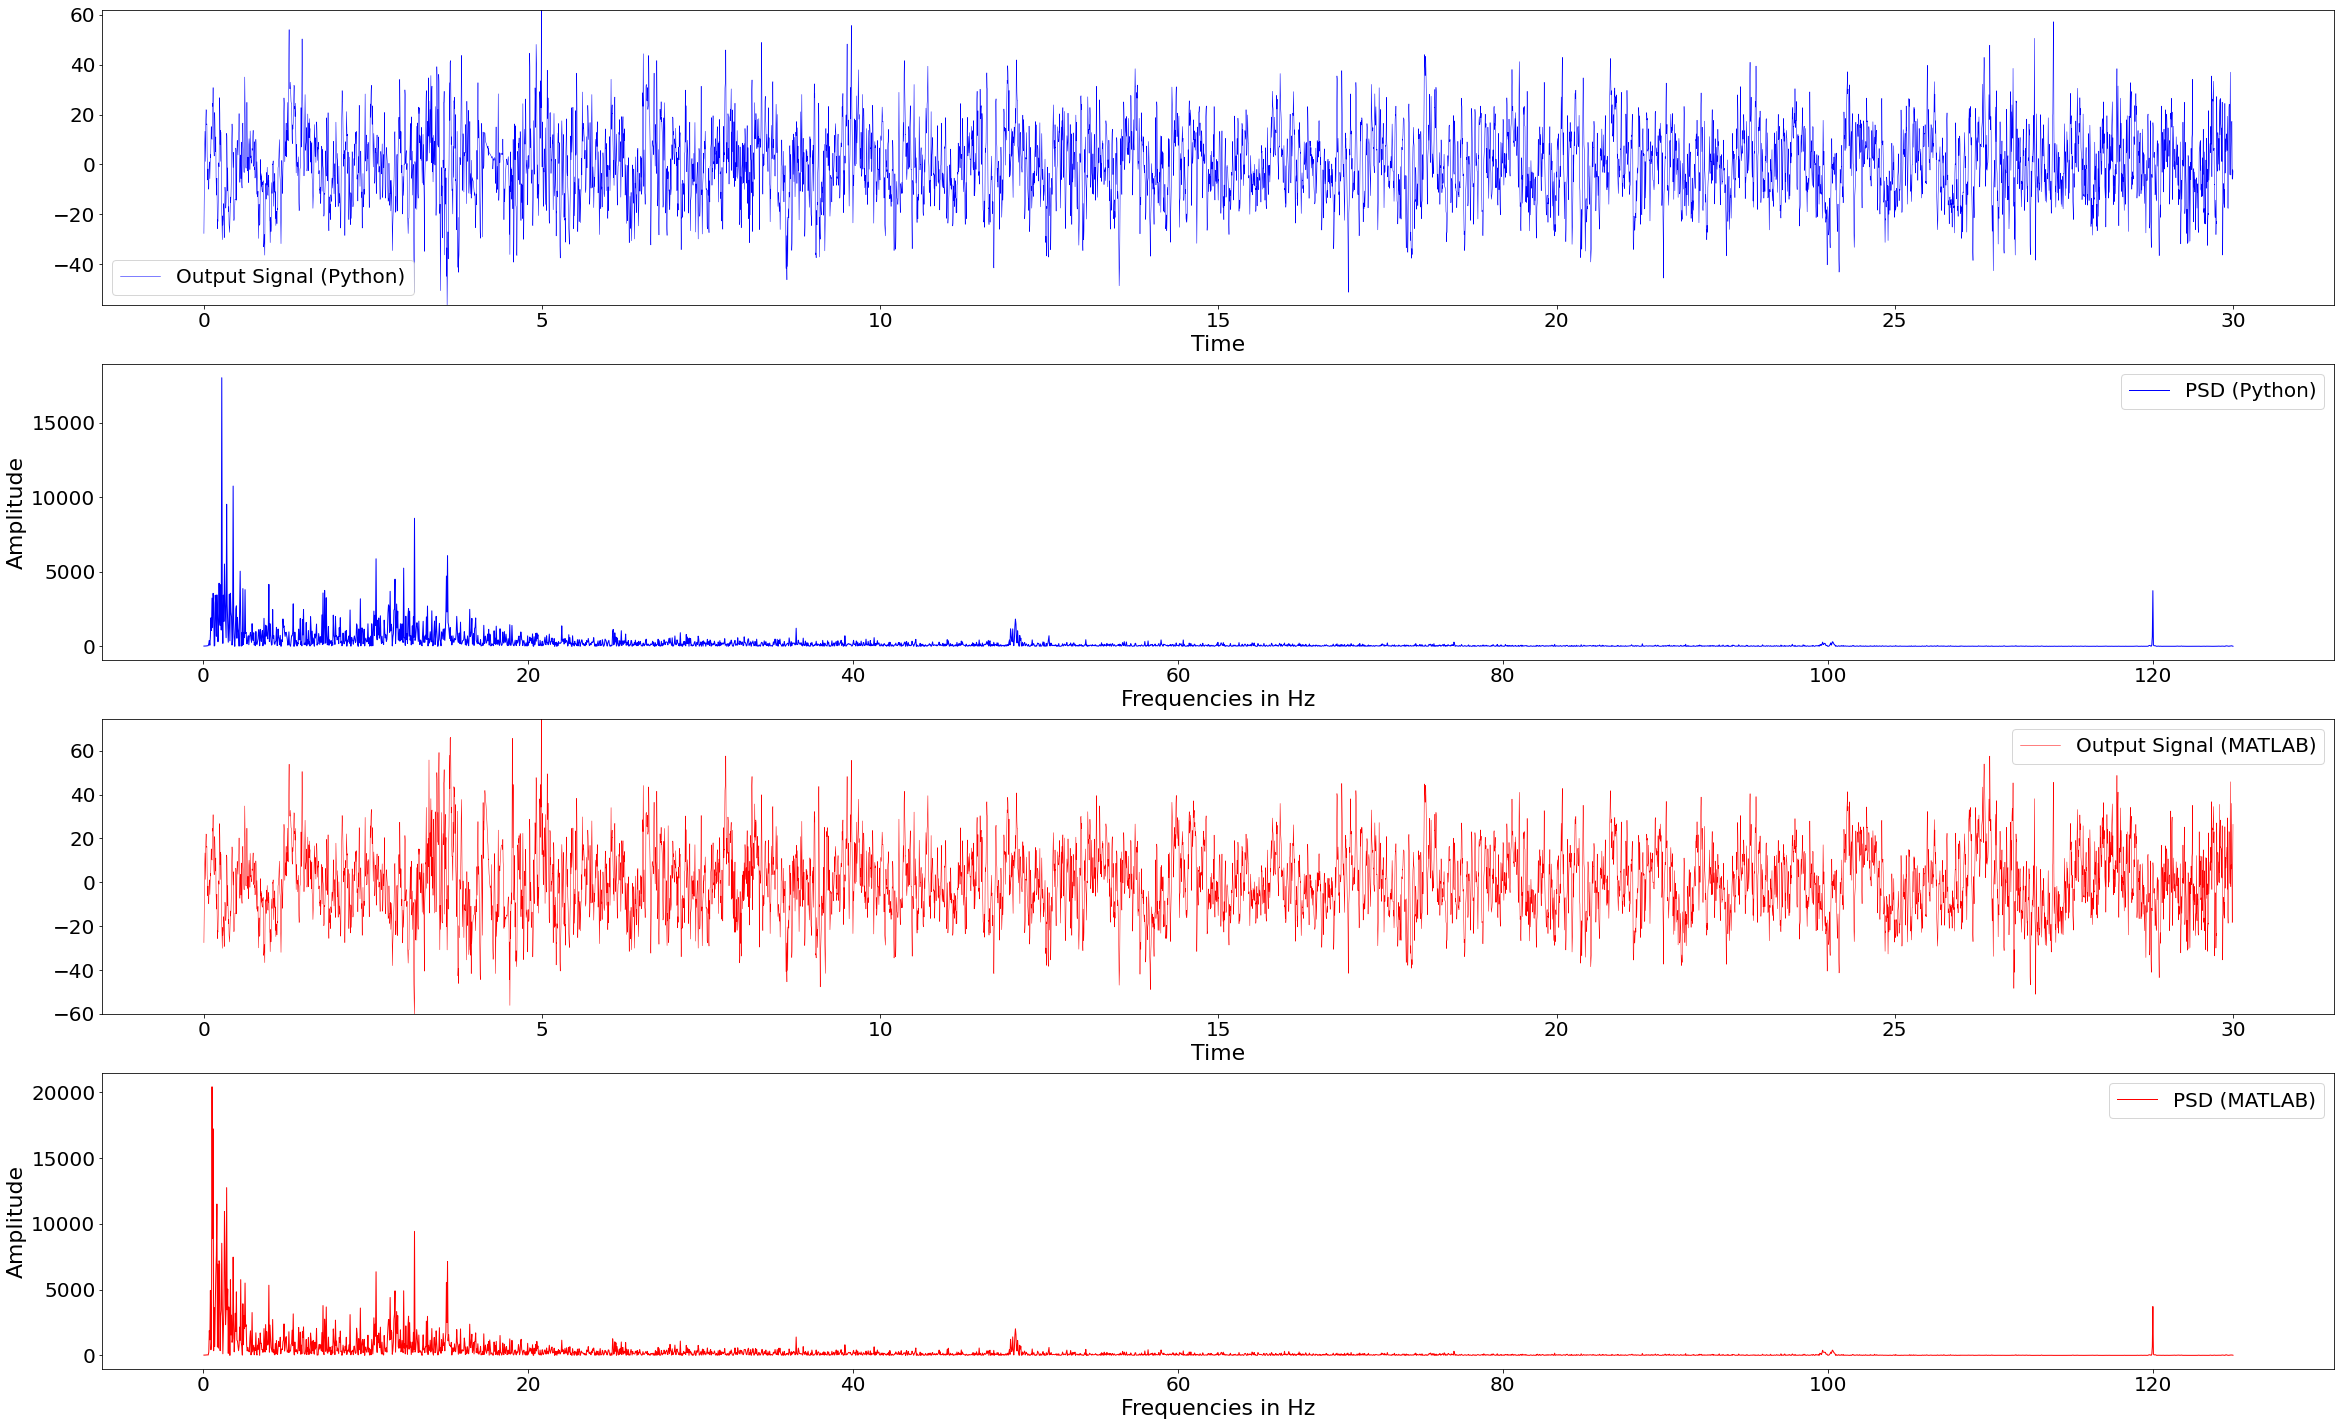

In [6]:
# Reading in and Plotting results from MATLAB
ExG_univ_m = np.transpose( np.genfromtxt("ExG_univ_m.csv", delimiter = ',') )
#       Compute Fourier Transform
t = ExG_in[0]
n = len(t)
fhat_univ_m = np.fft.fft(ExG_univ_m)
psd_univ_m = fhat_univ_m * np.conj(fhat_univ_m)/n


# Comparing both results
fig, ax = plt.subplots(4,1)
plt.rcParams['figure.figsize'] = [40, 25]
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', labelsize = MEDIUM_SIZE)    # fontsize of the x and y labels 

ax[0].plot(t, ExG_univ, color='b', lw=0.5, label='Output Signal (Python)')
ax[0].set_ylim([ExG_univ.min(), ExG_univ.max()])
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].plot(freq[idxs_half], np.abs(psd_univ[idxs_half]), color='b', lw=1, label='PSD (Python)')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(t, ExG_univ_m, color='r', lw=0.5, label='Output Signal (MATLAB)')
ax[2].set_ylim([ExG_univ_m.min(), ExG_univ_m.max()])
ax[2].set_xlabel('Time')
ax[2].legend()

ax[3].plot(freq[idxs_half], np.abs(psd_univ_m[idxs_half]), color='r', lw=1, label='PSD (MATLAB)')
ax[3].set_xlabel('Frequencies in Hz')
ax[3].set_ylabel('Amplitude')
ax[3].legend()

### b. Bayes

In [8]:
import numpy as np
import pywt
from wav_thd.ebayesthd_wav_dwt import ebayesthd_wav_dwt
import matplotlib.pyplot as plt 

# a. Reading in our ExG signal
ExG_in = np.transpose( np.genfromtxt("offline_exp_ExG-30s.csv", delimiter = ',') )
ExG_in = ExG_in[:, 1:]
# timestamps start at 0 s
ExG_in[0] = ExG_in[0] - ExG_in[0][0]
s_rate = 250
ln_freq = 50 # Line frequency = 50 Hz

# Reading in filtered signal
ExG_filt = np.transpose( np.genfromtxt("ExG_filt.csv", delimiter = ',') )

# Wavelet thresholding 
artifacts = ebayesthd_wav_dwt(ExG_filt, s_rate)

# Denoised signal
ExG_bayes = ExG_filt - artifacts

# Computing Fourier Transform
t = ExG_in[0]
dt = t[1] - t[0]
n = len(t)
freq = (1/(dt*n)) * np.arange(n) # frequency array
idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) # first half index
fhat_bayes = np.fft.fft(ExG_bayes)
psd_bayes = fhat_bayes * np.conj(fhat_bayes)/n

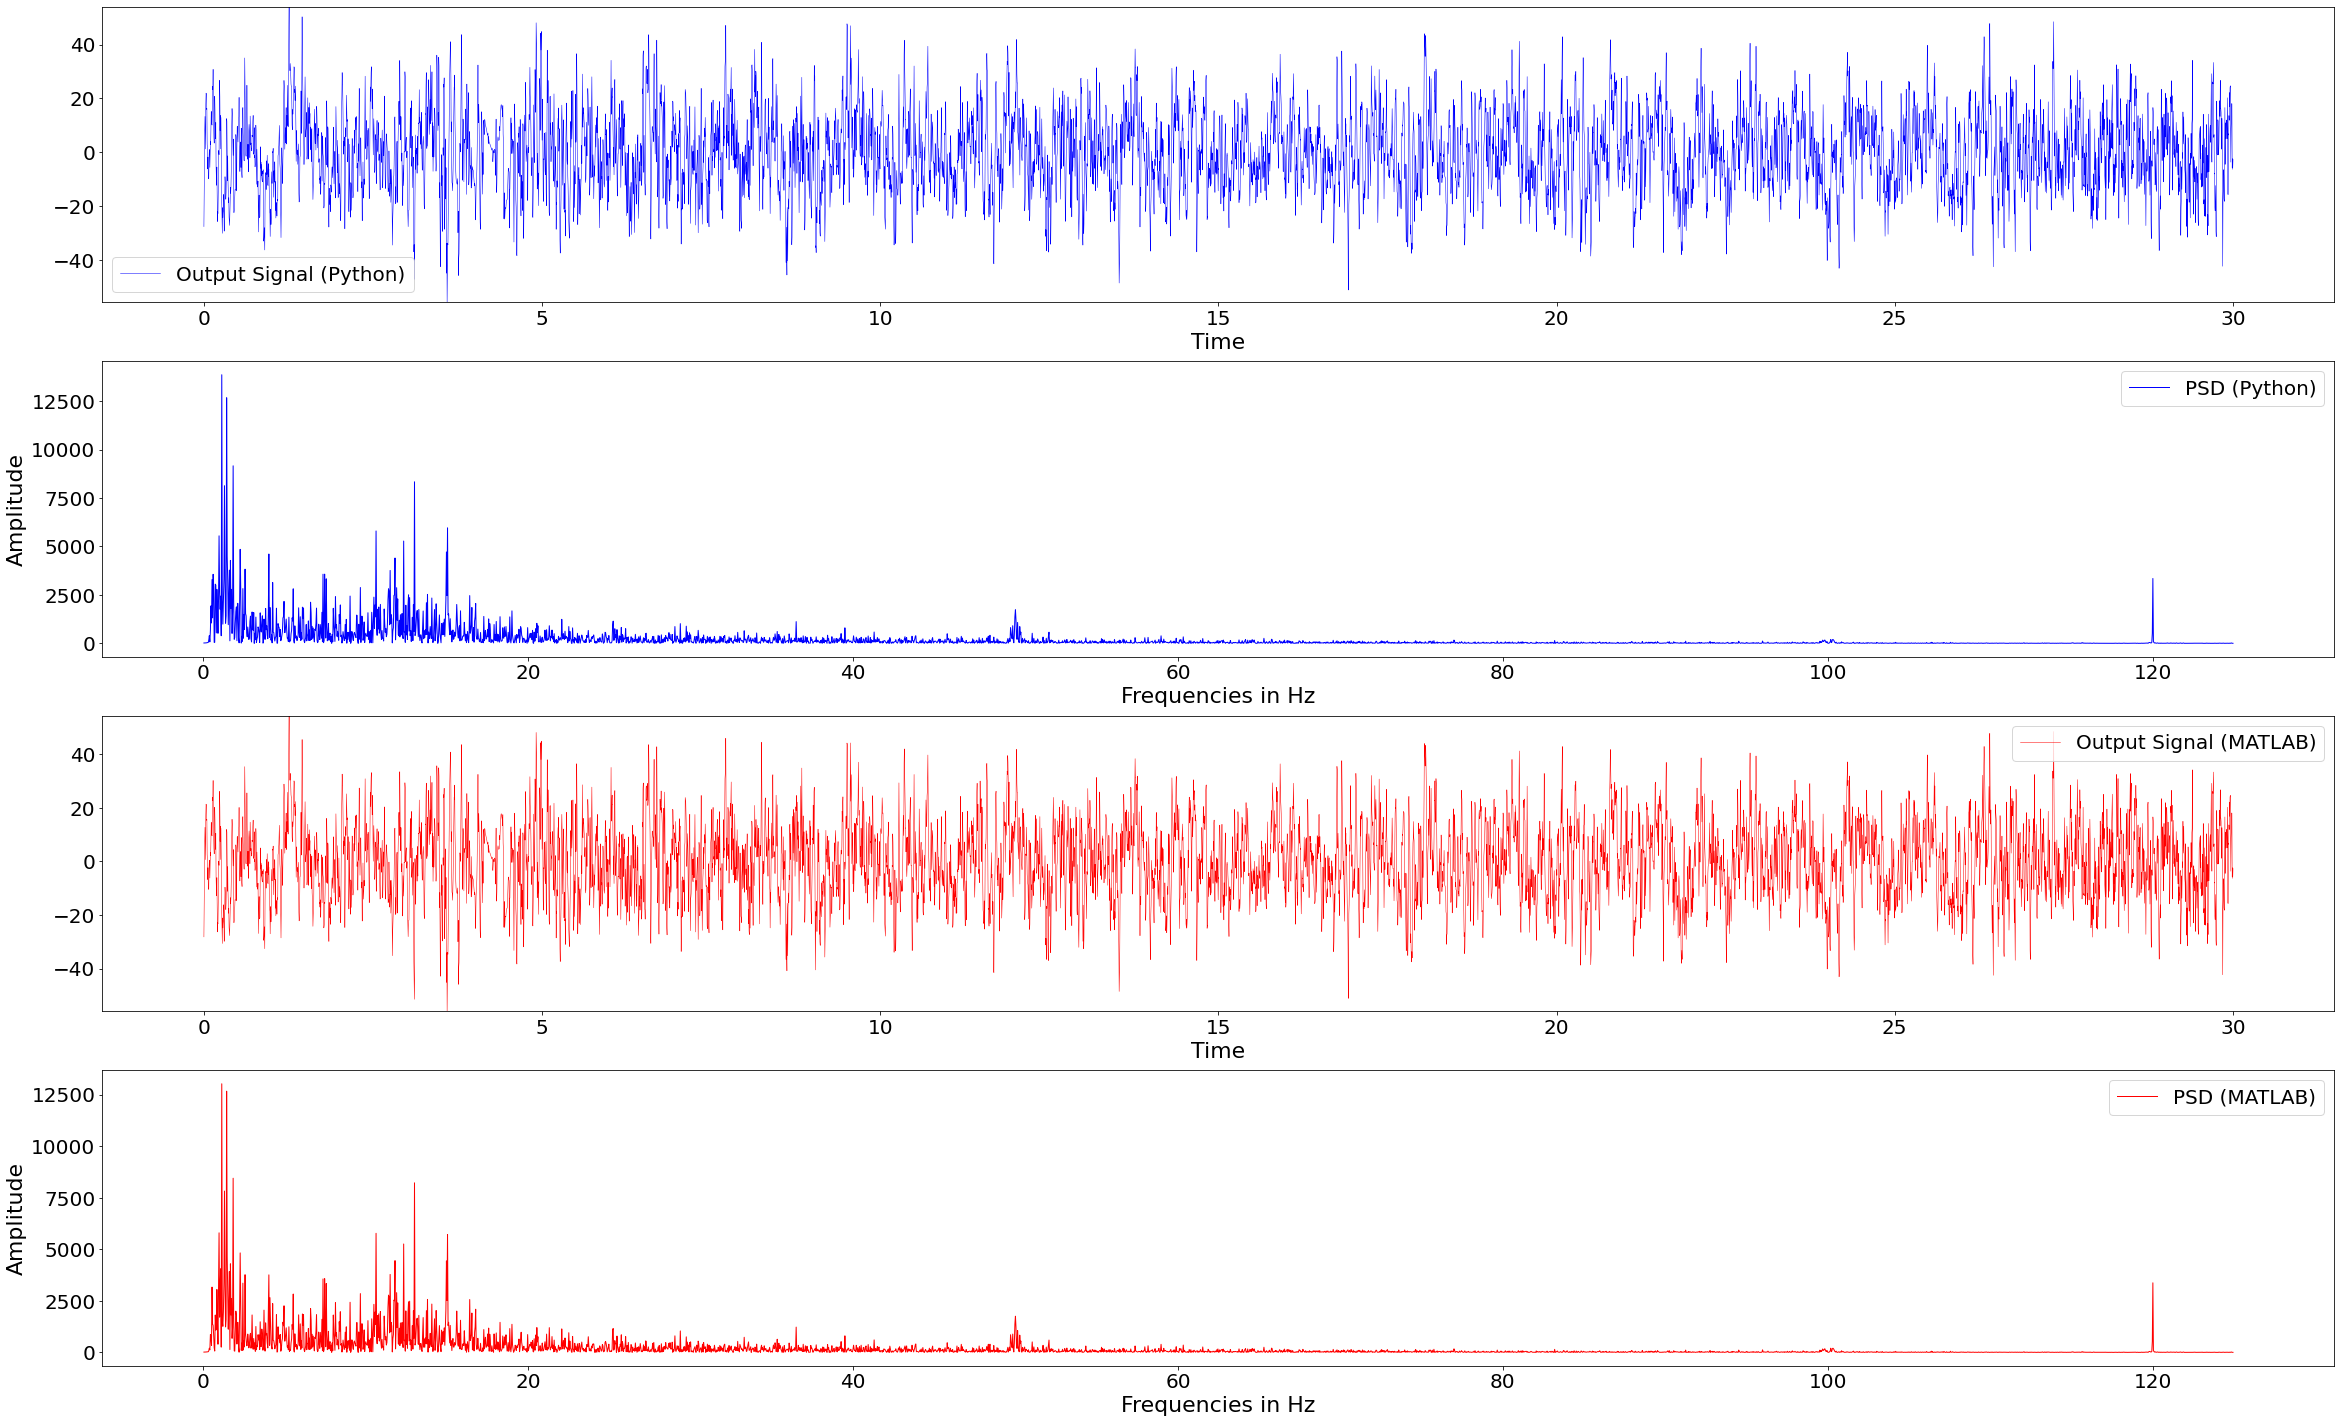

In [9]:
# Reading in and Plotting results from MATLAB
ExG_bayes_m = np.transpose( np.genfromtxt("ExG_bayes_m.csv", delimiter = ',') )
#       Compute Fourier Transform
t = ExG_in[0]
n = len(t)
fhat_bayes_m = np.fft.fft(ExG_bayes_m)
psd_bayes_m = fhat_bayes_m * np.conj(fhat_bayes_m)/n

# Comparing both results
fig, ax = plt.subplots(4,1)
plt.rcParams['figure.figsize'] = [40, 25]
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('xtick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', labelsize = MEDIUM_SIZE)    # fontsize of the x and y labels 

ax[0].plot(t, ExG_bayes, color='b', lw=0.5, label='Output Signal (Python)')
ax[0].set_ylim([ExG_bayes.min(), ExG_bayes.max()])
ax[0].set_xlabel('Time')
ax[0].legend()

ax[1].plot(freq[idxs_half], np.abs(psd_bayes[idxs_half]), color='b', lw=1, label='PSD (Python)')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(t, ExG_bayes_m, color='r', lw=0.5, label='Output Signal (MATLAB)')
ax[2].set_ylim([ExG_bayes_m.min(), ExG_bayes_m.max()])
ax[2].set_xlabel('Time')
ax[2].legend()

ax[3].plot(freq[idxs_half], np.abs(psd_bayes_m[idxs_half]), color='r', lw=1, label='PSD (MATLAB)')
ax[3].set_xlabel('Frequencies in Hz')
ax[3].set_ylabel('Amplitude')
ax[3].legend()